**Install Required Packages**

In [1]:
!pip install transformers datasets scikit-learn tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

**Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import DataCollatorWithPadding, create_optimizer
from datasets import Dataset

In [4]:
import pandas as pd
df = pd.read_csv("/content/processed_data.csv")
df.head()

,CATEGORY,CONTENT,PROCESSED_CONTENT
0,business,WASHINGTON — In an effort to deliver on Presid...,washington effort deliver president obama pled...
1,business,Latest Articles\n\nStarving for Income? Safe M...,latest article starving income safe money stoc...
2,business,Nigeria has overtaken South Africa as Africa's...,nigeria overtaken south africa africa largest ...
3,business,"Receiving Wide Coverage ...\n\nStress Tests, P...",receiving wide coverage stress test part ii ci...
4,business,The dollar steadied on Friday after a signific...,dollar steadied friday significant rise u prod...


In [12]:
df.drop_duplicates(inplace=True) # Correct the method name and add inplace=True to modify the DataFrame in place.

In [5]:
df.describe()

,CATEGORY,CONTENT,PROCESSED_CONTENT
count,26216,26216,26216
unique,4,26216,26147
top,business,The Intel\n\nEverything You Need to Know About...,submit article requested found please refresh ...
freq,6554,1,7


In [6]:
df["CATEGORY"].value_counts()

,count
CATEGORY,
business,6554
entertainment,6554
health,6554
technology,6554


**Load data**

In [13]:
print(df['CONTENT'][0])

WASHINGTON — In an effort to deliver on President Obama’s pledge last summer to tackle emissions that drive climate change, the White House announced a strategy to limit releases of methane, a highly potent greenhouse gas.

The methane strategy, disclosed Friday, is the most recent in a string of climate change initiatives that the White House has unveiled at a rapid pace in recent weeks. It lays the groundwork for regulations that could affect agriculture and the oil, gas and coal industries.

Carbon dioxide from the combustion of fossil fuels is the biggest contributor to climate change, but methane, the chief component of natural gas, is estimated to be more than 20 times more potent at trapping heat in the atmosphere.

Methane emissions make up 9% of the country’s greenhouse gas emissions and are on track to increase, officials said. Among the biggest sources of methane going into the atmosphere are leaks from oil and gas facilities; seepage from coal mines; landfills; and livestoc

**Prepare Data**

In [14]:

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['CATEGORY'])

# Split into train and test
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['CONTENT'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/20972 [00:00<?, ? examples/s]

Map:   0%|          | 0/5244 [00:00<?, ? examples/s]

**Prepare TensorFlow Datasets**

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Update to_tf_dataset function call for train and test datasets
tf_train_dataset = train_tokenized.to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_dataset = test_tokenized.to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)


**Load Model and Compile**

In [16]:
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

num_train_steps = len(tf_train_dataset) * 3
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=num_train_steps)

# Update the model compilation step
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Use appropriate loss function
              metrics=["accuracy"])

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

**Train the Model**

In [17]:
history = model.fit(tf_train_dataset, validation_data=tf_test_dataset, epochs=5)

Epoch 1/5
1311/1311 [==============================] - 1345s 1s/step - loss: 0.2364 - accuracy: 0.9271 - val_loss: 0.1188 - val_accuracy: 0.9609
Epoch 2/5
1311/1311 [==============================] - 1326s 1s/step - loss: 0.0940 - accuracy: 0.9696 - val_loss: 0.1094 - val_accuracy: 0.9676
Epoch 3/5
1311/1311 [==============================] - 1363s 1s/step - loss: 0.0571 - accuracy: 0.9804 - val_loss: 0.1037 - val_accuracy: 0.9683
Epoch 4/5
1311/1311 [==============================] - 1364s 1s/step - loss: 0.0465 - accuracy: 0.9851 - val_loss: 0.1037 - val_accuracy: 0.9683
Epoch 5/5
1311/1311 [==============================] - 1363s 1s/step - loss: 0.0462 - accuracy: 0.9855 - val_loss: 0.1037 - val_accuracy: 0.9683


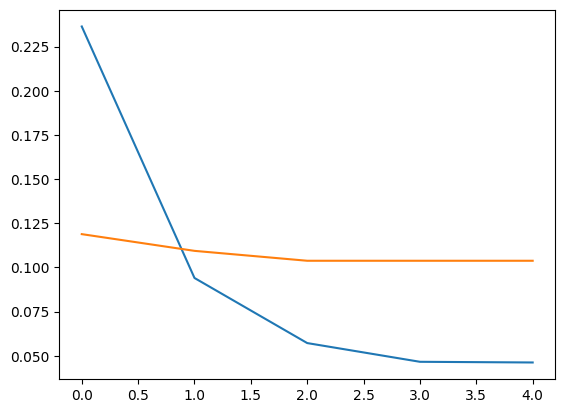

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

**Evaluate and Metrics**

328/328 [==============================] - 108s 324ms/step
               precision    recall  f1-score   support

     business       0.95      0.96      0.95      1335
entertainment       0.98      0.98      0.98      1326
       health       0.97      0.97      0.97      1272
   technology       0.97      0.97      0.97      1311

     accuracy                           0.97      5244
    macro avg       0.97      0.97      0.97      5244
 weighted avg       0.97      0.97      0.97      5244



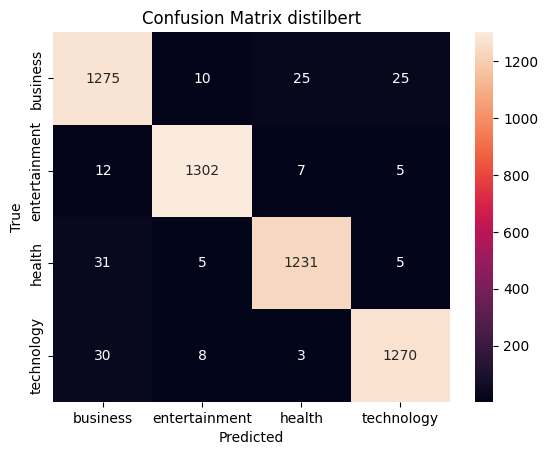

In [18]:
# Get predictions
y_true = test_labels
y_pred = model.predict(tf_test_dataset).logits
y_pred_labels = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_true, y_pred_labels, target_names=le.classes_))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix distilbert')
plt.show()


In [21]:
loss, accuracy = model.evaluate(tf_test_dataset, verbose=0)
print(f"Test Accuracy: {accuracy:.5f}")

Test Accuracy: 0.96834
